In [3]:
import numpy as np 
import urdf2casadi.urdfparser as u2c
from urdf2casadi.geometry import plucker
from urdf_parser_py.urdf import URDF, Pose
import PyKDL as kdl
import kdl_parser_py.urdf as kdlurdf
from timeit import Timer, timeit, repeat
import rbdl
import pybullet as pb



rbdl.Model (0x1cdde30)


In [ ]:
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0
        
def average(lst): 
    return sum(lst) / len(lst) 


def C_kdl_func():
    for j in range(njoints):
        q_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    kdl.ChainDynParam(kdlmodel, g_kdl).JntToCoriolis(q_kdl, qdot_kdl, C_kdl)


def C_u2c_func():   
    for j in range(njoints):
        q_none = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    C_u2c(q_none, qdot_none)
    
def C_pb_func():
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
    
    C_pb = pb.calculateInverseDynamics(pbmodel, q_none, qdot_none, qddot)
    
def C_rbdl_func():
    for j in range(njoints):
        q_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    rbdl.InverseDynamics(rbdlmodel, q_np, qdot_np, qddot_np, C_rbdl)



In [ ]:
#pbmodel = pb.loadURDF("pantilt.urdf")
sim = pb.connect(pb.DIRECT)
#pbmodel = pb.loadURDF("/urdf4timing/1dof.urdf")
ndofs = 32
urdf_nr = list(range(ndofs + 1))
urdf_nr.pop(0)

#storage for timing data
mediantime_kdl = [None]*ndofs
mediantime_u2c = [None]*ndofs
mediantime_rbdl = [None]*ndofs
mediantime_pb = [None]*ndofs
mintime_kdl = [None]*ndofs
mintime_u2c = [None]*ndofs
mintime_rbdl = [None]*ndofs
mintime_pb = [None]*ndofs
averagetime_kdl = [None]*ndofs
averagetime_u2c = [None]*ndofs
averagetime_rbdl = [None]*ndofs
averagetime_pb = [None]*ndofs

nitr = 50000
nrepeat = 10

model = rbdl.loadModel("./urdf4timing/32dof.urdf")
    
for i in range(ndofs):    
    print i
    path_to_urdf = "./urdf4timing/" + str(urdf_nr[i]) + "dof.urdf"
    path_to_urdf2 = "./urdf4timing/" + str(urdf_nr[i]) + "dof2.urdf"
    end_link = "link" + str(urdf_nr[i])
    root = 'base_link'
    tip = end_link
    
    ok, kdl_tree = kdlurdf.treeFromFile(path_to_urdf)
    kdlmodel = kdl_tree.getChain(root,tip)
    
    rbdlmodel = rbdl.loadModel(path_to_urdf2)
    pbmodel = pb.loadURDF(path_to_urdf2, useFixedBase=True)
    asd = u2c.URDFparser()
    robot_desc = asd.from_file(path_to_urdf)
    
    jlist, names, qmax, qmin = asd.get_joint_info(root, tip)
    njoints = len(jlist)

    g_kdl = kdl.Vector()
    
    #rbdl declarations
    q_np = np.zeros(njoints)
    qdot_np = np.zeros(njoints)
    qddot_np = np.zeros(njoints)
    C_rbdl = np.zeros(njoints)
    
    #kdl declatations
    q_kdl = kdl.JntArray(njoints)
    qdot_kdl = kdl.JntArray(njoints)
    C_kdl = kdl.JntArray(njoints)
    
    #u2c and pybullet declarations
    q_none = [None]*njoints
    qdot_none = [None]*njoints
    C_pb = [None]*njoints
    
    qddot = []
    for i in range(njoints):
        qddot.append(0.)
    
    C_u2c = asd.get_jointspace_bias_matrix(root, tip)
    timeit_u2c = repeat("C_u2c_func()", setup = "from __main__ import C_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c[i] = min(timeit_u2c)
    mediantime_u2c[i] = median(timeit_u2c)
    averagetime_u2c[i] = average(timeit_u2c)
    
    timeit_pb = repeat("C_pb_func()", setup = "from __main__ import C_pb_func", repeat = nrepeat, number = nitr)
    mintime_pb[i] = min(timeit_pb)
    mediantime_pb[i] = median(timeit_pb)
    averagetime_pb[i] = average(timeit_pb)
    
    timeit_rbdl = repeat("C_rbdl_func()", setup = "from __main__ import C_rbdl_func", repeat = nrepeat, number = nitr)
    mintime_rbdl[i] = min(timeit_rbdl)
    mediantime_rbdl[i] = median(timeit_rbdl)
    averagetime_rbdl[i] = average(timeit_rbdl)
    
    timeit_kdl = repeat("C_kdl_func()", setup = "from __main__ import C_kdl_func", repeat = nrepeat, number = nitr)
    mintime_kdl[i] = min(timeit_kdl)
    mediantime_kdl[i] = median(timeit_kdl)
    averagetime_kdl[i] = average(timeit_kdl)


In [9]:
print mintime_u2c



[0.6700751781463623, 0.8033030033111572, 0.8534181118011475, 0.9398379325866699, 0.9995028972625732, 1.0403709411621094, 1.1173858642578125, 1.1625559329986572, 1.2358441352844238, 1.2914049625396729, 1.3502638339996338, 1.4210340976715088, 1.4927358627319336, 1.531242847442627, 1.5925378799438477, 1.6582460403442383, 1.7331609725952148, 1.7993190288543701, 1.8500361442565918, 1.917734146118164, 1.9798839092254639, 2.0191500186920166, 2.1161210536956787, 2.1864449977874756, 2.2063679695129395, 2.3153328895568848, 2.2988710403442383, 2.4215009212493896, 2.437371015548706, 2.5381860733032227, 2.561940908432007, 2.6747419834136963]


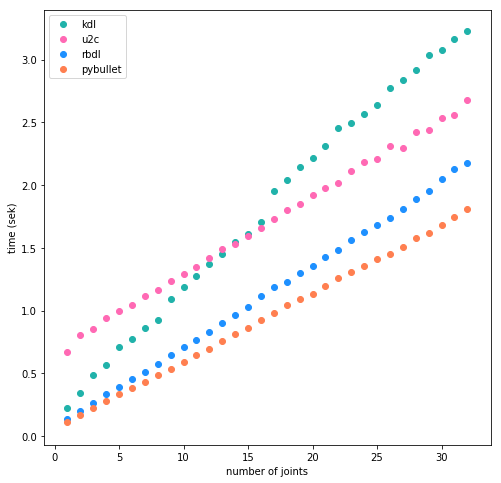

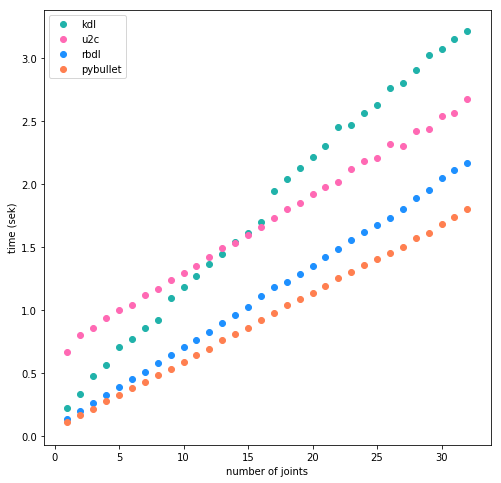

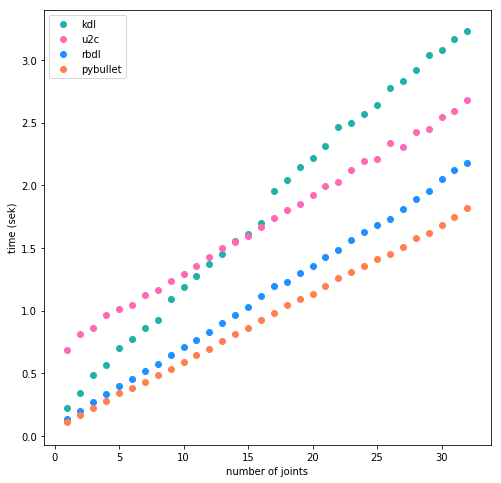

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (8, 8))
plt.scatter(joint_nr, mediantime_kdl, c='lightseagreen', label='kdl')
#plt.scatter(joint_nr, mediantime_u2c, c='hotpink', label='u2c')
plt.scatter(joint_nr, mintime_u2c, c='hotpink', label='u2c')
plt.scatter(joint_nr, mediantime_rbdl, c='dodgerblue', label='rbdl')
plt.scatter(joint_nr, mediantime_pb, c='coral', label='pybullet')
plt.xlabel("number of joints")
plt.ylabel("time (sek)")
plt.legend(loc='upper left')
med_fig.show()

min_fig = plt.figure(figsize = (8, 8))
plt.scatter(joint_nr, mintime_kdl, c='lightseagreen', label='kdl')
plt.scatter(joint_nr, mintime_u2c, c='hotpink', label='u2c')
#plt.scatter(joint_nr, mintime_u2c, c='mediumvioletred', label='u2c')
plt.scatter(joint_nr, mintime_rbdl, c='dodgerblue', label='rbdl')
plt.scatter(joint_nr, mintime_pb, c='coral', label='pybullet')
plt.xlabel("number of joints")
plt.ylabel("time (sek)")
plt.legend(loc='upper left')
min_fig.show()


avg_fig = plt.figure(figsize = (8, 8))
plt.scatter(joint_nr, averagetime_kdl, c='lightseagreen', label='kdl')
plt.scatter(joint_nr, averagetime_u2c, c='hotpink', label='u2c')
plt.scatter(joint_nr, averagetime_rbdl, c='dodgerblue', label='rbdl')
plt.scatter(joint_nr, averagetime_pb, c='coral', label='pybullet')
plt.xlabel("number of joints")
plt.ylabel("time (sek)")
plt.legend(loc='upper left')
avg_fig.show()

In [19]:
#min_fig = plt.figure(figsize = (8, 8))
#plt.scatter(joint_nr, mintime_kdl, c='r', marker='x', label='kdl')
#plt.scatter(joint_nr, mintime_u2c, c='fuchsia', label='u2c')
#plt.scatter(joint_nr, mintime_rbdl, c='b', marker='s', label='rbdl')
#plt.scatter(joint_nr, mintime_pb, c='r', marker='s', label='pybullet')
#plt.legend(loc='upper left')
#min_fig.show()

[Text(0,0,'pybullet'), Text(0,0,'RBDL'), Text(0,0,'U2C'), Text(0,0,'KDL')]

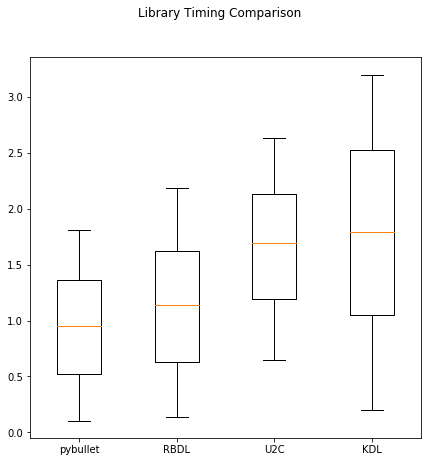

In [7]:
timing_scores = [mintime_pb, mintime_rbdl, mintime_u2c, mintime_kdl]
names = ["pybullet", "RBDL", "U2C", "KDL"]#, "RBDL", "pybullet"]
boxplot = plt.figure(figsize = (7, 7))
boxplot.suptitle("Library Timing Comparison")
ax = boxplot.add_subplot(111)
ax.boxplot(timing_scores)
#plt.boxplot(timing_scores)
ax.set_xticklabels(names)
